Kaggle Competition: https://www.kaggle.com/competitions/womens-march-mania-2022

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [5]:
DATA_PATH = '/Users/evelyn.cy/UMN_MSBA/side_project/Kaggle-MarchWomanMania/WDataFiles_Stage1/'

for filename in os.listdir(DATA_PATH):
    print(filename)

WNCAATourneySlots.csv
538ratingsWomen.csv
WTeams.csv
WSampleSubmissionStage1.csv
WNCAATourneyDetailedResults.csv
WNCAATourneyCompactResults.csv
WSeasons.csv
Cities.csv
WRegularSeasonCompactResults.csv
WTeamSpellings.csv
WRegularSeasonDetailedResults.csv
WNCAATourneySeeds.csv
WTeamConferences.csv
Conferences.csv
WGameCities.csv


# Feature Engeering

## Season Compact Results
##### Features Computation
For each team at each season, I created the following columns: 
- num_win: Number of wins
- num_loss: Number of losses
- gap_win: Average score gap of wins
- gap_loss: Average score gap of losses

And then I computed two following features using the above columns: 
- Win Ratio = Number of wins / (Number of wins + Number of losses)
- Average score gap = [ (num_win * gap_win) - (num_loss * gap_loss) ] / (num_win + num_loss)

In [204]:
# Import seasonal  compact data
# Season began from 1998 to 2021
# Note: In order to merge both compact and detail dataset, we use data only from season 2010 to 2021
df_season_compact = pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv")
df_season_compact.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_season_compact = df_season_compact[df_season_compact.Season > 2009]
df_season_compact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
55101,2010,11,3103,63,3237,49
55102,2010,11,3104,73,3399,68
55103,2010,11,3110,71,3224,59


In [205]:
# Create scoreGap column that is going to be used for Average score gap of wins/losses
df_season_compact['ScoreGap'] = df_season_compact['WScore'] - df_season_compact['LScore']
df_season_compact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
55101,2010,11,3103,63,3237,49,14
55102,2010,11,3104,73,3399,68,5
55103,2010,11,3110,71,3224,59,12


In [206]:
# Creating columns of "Number of wins" / "Number of losses" for each winning/lossing team in each season
num_win = df_season_compact.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

num_loss = df_season_compact.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})


In [207]:
# Creating columns of "Average Score Gap of wins" / "Average Score Gap of losses" for each winning/lossing team in each season
gap_win = df_season_compact.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

gap_loss = df_season_compact.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})


In [208]:
# Merge columns from season compact dataset
df_features_season_w = df_season_compact.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_compact.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)
df_features_detail = df_features_season.copy()

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')


In [209]:
# Calculating features
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

# df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)


## Season Detail Results
##### Features Computation
For each team at each season, I compute the average data of the following data: 
- FGM - field goals made
- FGM3 - three pointers made
- FTM - free throws made
- OR - offensive rebounds
- DR - defensive rebounds
- Ast - assists
- TO - turnovers committed
- Stl - steals
- Blk - blocks
- PF - personal fouls committed

In [210]:
# Import seasonal data
# Season began from 2010 to 2021
w_columns = ['Season','WTeamID','WFGM','WFGM3','WFTM','WOR','WDR','WAst','WTO','WStl','WBlk','WPF']
l_columns = ['Season','LTeamID','LFGM','LFGM3','LFTM','LOR','LDR','LAst','LTO','LStl','LBlk','LPF']
df_season_detail = pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv")
df_season_detailWin = df_season_detail[w_columns]
df_season_detailLoss = df_season_detail[l_columns]
df_season_detailWin.head(3)

,Season,WTeamID,WFGM,WFGM3,WFTM,WOR,WDR,WAst,WTO,WStl,WBlk,WPF
0,2010,3103,23,5,12,10,26,14,18,7,0,15
1,2010,3104,26,5,16,16,31,15,20,5,2,25
2,2010,3110,29,6,7,14,23,18,13,6,2,17


In [211]:
# Calculating feature: Average Score of detailed result for each winning/lossing team in each season
rename_win_column  = ['avg'+col for col in w_columns[2:]]
rename_loss_column  = ['avg'+col for col in l_columns[2:]]

avgdetail_win = df_season_detailWin.groupby(['Season', 'WTeamID']).mean().reset_index()
avgdetail_win = avgdetail_win.rename(columns=dict(zip(w_columns[2:], rename_win_column)))

avgdetail_loss = df_season_detailLoss.groupby(['Season', 'LTeamID']).mean().reset_index()
avgdetail_loss = avgdetail_loss.rename(columns=dict(zip(l_columns[2:], rename_loss_column)))

avgdetail_win

,Season,WTeamID,avgWFGM,avgWFGM3,avgWFTM,avgWOR,avgWDR,avgWAst,avgWTO,avgWStl,avgWBlk,avgWPF
0,2010,3102,23.000000,6.000000,16.000000,11.000000,29.000000,13.000000,14.000000,9.000000,1.000000,10.000000
1,2010,3103,23.941176,4.352941,14.117647,14.176471,25.764706,14.235294,16.882353,8.705882,2.705882,16.058824
2,2010,3104,28.000000,4.818182,12.000000,14.363636,28.000000,17.181818,20.545455,8.454545,3.000000,18.454545
3,2010,3105,21.785714,3.142857,19.714286,11.285714,25.571429,11.285714,25.714286,8.928571,5.642857,18.714286
4,2010,3106,19.583333,2.250000,18.416667,14.916667,25.583333,12.166667,19.250000,7.500000,5.333333,21.750000
...,...,...,...,...,...,...,...,...,...,...,...,...
4494,2022,3468,25.000000,8.000000,10.000000,7.000000,21.000000,13.000000,14.000000,6.000000,2.000000,13.000000
4495,2022,3469,25.333333,9.333333,11.333333,8.666667,30.666667,12.333333,18.666667,6.000000,3.000000,13.666667
4496,2022,3470,21.625000,4.500000,11.625000,9.000000,24.000000,11.375000,18.625000,7.750000,5.875000,12.500000
4497,2022,3471,23.875000,9.875000,9.750000,8.250000,29.125000,16.250000,12.250000,5.500000,3.000000,15.875000


In [212]:
# Merge features from season detail dataset
avgdetail_win = avgdetail_win.rename(columns = {'WTeamID':'TeamID'})
avgdetail_loss = avgdetail_loss.rename(columns = {'LTeamID':'TeamID'})

df_features_detail = df_features_detail.merge(avgdetail_win, on=['Season', 'TeamID'], how='left')
df_features_detail = df_features_detail.merge(avgdetail_loss, on=['Season', 'TeamID'], how='left')

# fill the missing values
df_features_detail.fillna(0, inplace=True)  


In [213]:
df_features_detail.head(3)

,Season,TeamID,avgWFGM,avgWFGM3,avgWFTM,avgWOR,avgWDR,avgWAst,avgWTO,avgWStl,avgWBlk,avgWPF,avgLFGM,avgLFGM3,avgLFTM,avgLOR,avgLDR,avgLAst,avgLTO,avgLStl,avgLBlk,avgLPF
0,2010,3102,23.000000,6.000000,16.000000,11.000000,29.000000,13.000000,14.000000,9.000000,1.000000,10.000000,19.000000,4.518519,8.703704,12.518519,19.185185,10.148148,17.851852,5.925926,0.629630,15.148148
1,2010,3103,23.941176,4.352941,14.117647,14.176471,25.764706,14.235294,16.882353,8.705882,2.705882,16.058824,20.000000,3.384615,13.461538,14.230769,20.692308,12.384615,20.076923,7.153846,2.000000,19.461538
2,2010,3104,28.000000,4.818182,12.000000,14.363636,28.000000,17.181818,20.545455,8.454545,3.000000,18.454545,22.722222,4.055556,9.333333,14.555556,24.666667,10.611111,18.333333,6.722222,2.888889,21.611111


## Tourney Results

In [214]:
df_tourney_results = pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv")
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

## 538 Ratings
* Thanks to Raddar ! https://www.kaggle.com/raddar/ncaa-women-538-team-ratings

In [215]:
df_538 = pd.read_csv(DATA_PATH + "538ratingsWomen.csv")
df_538.drop('TeamName', axis=1, inplace=True)

df_538.head()

,Season,TeamID,538rating
0,2016,3163,113.09
1,2016,3124,101.59
2,2016,3323,101.07
3,2016,3376,101.07
4,2016,3268,99.01


# Train Data

In [227]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


## Adding Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [228]:
df_seeds = pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv")
df_seeds.head(3)

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112


In [229]:
# Merge seed of wining team
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

# Merge seed of lossing team
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

df.head(2)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,Z12,Z05
1,2016,137,3113,74,3308,52,Z02,Z15


In [230]:
def transform_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(transform_seed)
df['SeedL'] = df['SeedL'].apply(transform_seed)

df.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,12,5
1,2016,137,3113,74,3308,52,2,15


## Adding Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [231]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

df.head(3)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,GapWinsW,GapLossesW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,GapWinsL,GapLossesL,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500


## Adding Detail Results


In [233]:
df = pd.merge(
    df,
    avgdetail_win,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    avgdetail_loss,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop(columns='TeamID', axis=1)

df.head(3)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,GapWinsW,GapLossesW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,GapWinsL,GapLossesL,WinRatioL,GapAvgL,avgWFGM,avgWFGM3,avgWFTM,avgWOR,avgWDR,avgWAst,avgWTO,avgWStl,avgWBlk,avgWPF,avgLFGM,avgLFGM3,avgLFTM,avgLOR,avgLDR,avgLAst,avgLTO,avgLStl,avgLBlk,avgLPF
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000,28.555556,2.222222,13.444444,14.148148,25.222222,16.666667,14.074074,10.222222,2.555556,16.074074,25.25,6.250000,11.625000,15.250000,22.125,12.625000,21.625000,9.875000,4.375000,25.500000
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286,24.160000,5.360000,11.640000,13.640000,23.280000,15.280000,14.800000,9.560000,2.520000,16.320000,21.25,7.500000,7.250000,10.750000,21.750,10.250000,19.000000,9.000000,3.500000,18.750000
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500,26.894737,4.894737,11.263158,12.947368,22.157895,15.105263,17.789474,13.368421,3.368421,17.368421,25.00,2.111111,7.777778,12.444444,22.000,12.555556,13.222222,6.777778,2.444444,17.222222


## Adding 538 Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [235]:
df = pd.merge(
    df,
    df_538,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

df = pd.merge(
    df, 
    df_538, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

df.head(3)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,GapWinsW,GapLossesW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,GapWinsL,GapLossesL,WinRatioL,GapAvgL,avgWFGM,avgWFGM3,avgWFTM,avgWOR,avgWDR,avgWAst,avgWTO,avgWStl,avgWBlk,avgWPF,avgLFGM,avgLFGM3,avgLFTM,avgLOR,avgLDR,avgLAst,avgLTO,avgLStl,avgLBlk,avgLPF,538ratingW,538ratingL
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000,28.555556,2.222222,13.444444,14.148148,25.222222,16.666667,14.074074,10.222222,2.555556,16.074074,25.25,6.250000,11.625000,15.250000,22.125,12.625000,21.625000,9.875000,4.375000,25.500000,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286,24.160000,5.360000,11.640000,13.640000,23.280000,15.280000,14.800000,9.560000,2.520000,16.320000,21.25,7.500000,7.250000,10.750000,21.750,10.250000,19.000000,9.000000,3.500000,18.750000,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500,26.894737,4.894737,11.263158,12.947368,22.157895,15.105263,17.789474,13.368421,3.368421,17.368421,25.00,2.111111,7.777778,12.444444,22.000,12.555556,13.222222,6.777778,2.444444,17.222222,80.17,82.19


## Adding symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [238]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    win_rename.update({c : c[4:] + "A" for c in df.columns if c.startswith('avgW')})
    win_rename.update({c : c[4:] + "B" for c in df.columns if c.startswith('avgL')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    lose_rename.update({c : c[4:] + "B" for c in df.columns if c.startswith('avgW')})
    lose_rename.update({c : c[4:] + "A" for c in df.columns if c.startswith('avgL')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

df = add_loosing_matches(df)
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,GapWinsA,GapLossesA,WinRatioA,GapAvgA,NumWinsB,NumLossesB,GapWinsB,GapLossesB,WinRatioB,GapAvgB,FGMA,FGM3A,FTMA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGMB,FGM3B,FTMB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,538ratingA,538ratingB
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000,28.555556,2.222222,13.444444,14.148148,25.222222,16.666667,14.074074,10.222222,2.555556,16.074074,25.250000,6.250000,11.625000,15.250000,22.125000,12.625000,21.625000,9.875000,4.375000,25.500000,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286,24.160000,5.360000,11.640000,13.640000,23.280000,15.280000,14.800000,9.560000,2.520000,16.320000,21.250000,7.500000,7.250000,10.750000,21.750000,10.250000,19.000000,9.000000,3.500000,18.750000,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500,26.894737,4.894737,11.263158,12.947368,22.157895,15.105263,17.789474,13.368421,3.368421,17.368421,25.000000,2.111111,7.777778,12.444444,22.000000,12.555556,13.222222,6.777778,2.444444,17.222222,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,33.0,1.0,25.575758,7.000000,0.970588,24.617647,22.0,9.0,19.818182,11.888889,0.709677,10.612903,30.363636,3.454545,14.545455,14.575758,31.393939,21.212121,15.303030,8.666667,6.090909,14.787879,21.333333,8.222222,11.777778,13.888889,24.222222,10.444444,16.444444,8.333333,4.000000,15.333333,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,25.0,8.0,24.640000,9.875000,0.757576,16.272727,27.0,5.0,20.740741,13.400000,0.843750,15.406250,32.760000,8.840000,9.080000,14.720000,27.240000,22.000000,13.160000,10.560000,2.440000,14.920000,21.200000,5.600000,10.000000,16.200000,25.200000,11.800000,16.800000,8.600000,3.200000,22.400000,90.08,83.04


In [240]:
df.drop(['NumWinsA','NumLossesA','GapWinsA','GapLossesA','NumWinsB','NumLossesB','GapWinsB','GapLossesB'], axis = 1, inplace = True)
df.head()



,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,FGMA,FGM3A,FTMA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGMB,FGM3B,FTMB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,538ratingA,538ratingB
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000,28.555556,2.222222,13.444444,14.148148,25.222222,16.666667,14.074074,10.222222,2.555556,16.074074,25.250000,6.250000,11.625000,15.250000,22.125000,12.625000,21.625000,9.875000,4.375000,25.500000,80.90,83.36
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286,24.160000,5.360000,11.640000,13.640000,23.280000,15.280000,14.800000,9.560000,2.520000,16.320000,21.250000,7.500000,7.250000,10.750000,21.750000,10.250000,19.000000,9.000000,3.500000,18.750000,91.32,71.42
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500,26.894737,4.894737,11.263158,12.947368,22.157895,15.105263,17.789474,13.368421,3.368421,17.368421,25.000000,2.111111,7.777778,12.444444,22.000000,12.555556,13.222222,6.777778,2.444444,17.222222,80.17,82.19
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903,30.363636,3.454545,14.545455,14.575758,31.393939,21.212121,15.303030,8.666667,6.090909,14.787879,21.333333,8.222222,11.777778,13.888889,24.222222,10.444444,16.444444,8.333333,4.000000,15.333333,101.59,72.69
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250,32.760000,8.840000,9.080000,14.720000,27.240000,22.000000,13.160000,10.560000,2.440000,14.920000,21.200000,5.600000,10.000000,16.200000,25.200000,11.800000,16.800000,8.600000,3.200000,22.400000,90.08,83.04


## Converting to Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [242]:
cols_to_diff = ['Seed','WinRatio','GapAvg','538rating','FGM','FGM3','FTM','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [243]:
df.columns

Index(['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB', 'SeedA',
       'SeedB', 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'FGMA',
       'FGM3A', 'FTMA', 'ORA', 'DRA', 'AstA', 'TOA', 'StlA', 'BlkA', 'PFA',
       'FGMB', 'FGM3B', 'FTMB', 'ORB', 'DRB', 'AstB', 'TOB', 'StlB', 'BlkB',
       'PFB', '538ratingA', '538ratingB', 'SeedDiff', 'WinRatioDiff',
       'GapAvgDiff', '538ratingDiff', 'FGMDiff', 'FGM3Diff', 'FTMDiff',
       'ORDiff', 'DRDiff', 'AstDiff', 'TODiff', 'StlDiff', 'BlkDiff',
       'PFDiff'],
      dtype='object')

# Test Data

In [245]:
df_test = pd.read_csv(DATA_PATH + "WSampleSubmissionStage1.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))
df_test.head(3)

,ID,Pred,Season,TeamIdA,TeamIdB
0,2016_3106_3107,0.5,2016,3106,3107
1,2016_3106_3113,0.5,2016,3106,3113
2,2016_3106_3119,0.5,2016,3106,3119


## Adding Seeds

In [247]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'})

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'})


In [249]:
df_test['SeedA'] = df_test['SeedA'].apply(transform_seed)
df_test['SeedB'] = df_test['SeedB'].apply(transform_seed)

## Adding Season Stats

In [251]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)


In [255]:
df_test.drop(['NumWinsA','NumLossesA','GapWinsA','GapLossesA','NumWinsB','NumLossesB','GapWinsB','GapLossesB'], axis = 1, inplace = True)
df_test.head()


,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2016_3106_3107,0.5,2016,3106,3107,15,12,0.62069,4.0,0.870968,18.677419
1,2016_3106_3113,0.5,2016,3106,3113,15,2,0.62069,4.0,0.806452,9.258065
2,2016_3106_3119,0.5,2016,3106,3119,15,13,0.62069,4.0,0.933333,20.066667
3,2016_3106_3120,0.5,2016,3106,3120,15,9,0.62069,4.0,0.612903,3.032258
4,2016_3106_3124,0.5,2016,3106,3124,15,1,0.62069,4.0,0.970588,24.617647


## Adding Detail Results

In [260]:
df_test = pd.merge(
    df_test,
    avgdetail_win,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    avgdetail_loss,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop(columns='TeamID', axis=1)

df_test.head(3)


,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,avgWFGM,avgWFGM3,avgWFTM,avgWOR,avgWDR,avgWAst,avgWTO,avgWStl,avgWBlk,avgWPF,avgLFGM,avgLFGM3,avgLFTM,avgLOR,avgLDR,avgLAst,avgLTO,avgLStl,avgLBlk,avgLPF
0,2016_3106_3107,0.5,2016,3106,3107,15,12,0.62069,4.0,0.870968,18.677419,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,22.500000,3.250000,11.000000,9.000000,20.750000,13.000000,16.75,10.000000,2.0,17.500000
1,2016_3106_3113,0.5,2016,3106,3113,15,2,0.62069,4.0,0.806452,9.258065,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,21.333333,3.666667,10.166667,13.833333,21.666667,12.333333,14.50,6.333333,2.0,17.833333
2,2016_3106_3119,0.5,2016,3106,3119,15,13,0.62069,4.0,0.933333,20.066667,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,26.000000,8.000000,5.000000,10.000000,21.000000,14.500000,16.00,5.500000,7.0,20.000000


## Adding 538 Ratings

In [261]:
df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

df_test = pd.merge(
    df_test,
    df_538,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

df_test.head()


,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,avgWFGM,avgWFGM3,avgWFTM,avgWOR,avgWDR,avgWAst,avgWTO,avgWStl,avgWBlk,avgWPF,avgLFGM,avgLFGM3,avgLFTM,avgLOR,avgLDR,avgLAst,avgLTO,avgLStl,avgLBlk,avgLPF,538ratingA,538ratingB
0,2016_3106_3107,0.5,2016,3106,3107,15,12,0.62069,4.0,0.870968,18.677419,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,22.500000,3.250000,11.000000,9.000000,20.750000,13.000000,16.750000,10.000000,2.000000,17.500000,59.87,80.90
1,2016_3106_3113,0.5,2016,3106,3113,15,2,0.62069,4.0,0.806452,9.258065,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,21.333333,3.666667,10.166667,13.833333,21.666667,12.333333,14.500000,6.333333,2.000000,17.833333,59.87,91.32
2,2016_3106_3119,0.5,2016,3106,3119,15,13,0.62069,4.0,0.933333,20.066667,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,26.000000,8.000000,5.000000,10.000000,21.000000,14.500000,16.000000,5.500000,7.000000,20.000000,59.87,79.02
3,2016_3106_3120,0.5,2016,3106,3120,15,9,0.62069,4.0,0.612903,3.032258,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,19.666667,2.916667,7.666667,14.250000,21.333333,10.083333,18.583333,8.166667,2.333333,20.166667,59.87,80.17
4,2016_3106_3124,0.5,2016,3106,3124,15,1,0.62069,4.0,0.970588,24.617647,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,18.000000,4.000000,5.000000,16.000000,24.000000,7.000000,18.000000,10.000000,6.000000,15.000000,59.87,101.59


## Adding Difference

In [264]:
def add_loosing_matches(df):
    win_rename = {}
    win_rename.update({c : c[4:] + "A" for c in df.columns if c.startswith('avgW')})
    win_rename.update({c : c[4:] + "B" for c in df.columns if c.startswith('avgL')})
    
    lose_rename = {}
    lose_rename.update({c : c[4:] + "B" for c in df.columns if c.startswith('avgW')})
    lose_rename.update({c : c[4:] + "A" for c in df.columns if c.startswith('avgL')})
    
    df = df.rename(columns=win_rename)
    df = df.rename(columns=lose_rename)
    
    return df

df_test = add_loosing_matches(df_test)

In [268]:
cols_to_diff = ['Seed','WinRatio','GapAvg','538rating','FGM','FGM3','FTM','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,FGMA,FGM3A,FTMA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGMB,FGM3B,FTMB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,538ratingA,538ratingB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,FGMDiff,FGM3Diff,FTMDiff,ORDiff,DRDiff,AstDiff,TODiff,StlDiff,BlkDiff,PFDiff
0,2016_3106_3107,0.5,2016,3106,3107,15,12,0.62069,4.0,0.870968,18.677419,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,22.500000,3.250000,11.000000,9.000000,20.750000,13.000000,16.750000,10.000000,2.000000,17.500000,59.87,80.90,3,-0.250278,-14.677419,-21.03,0.944444,1.138889,6.277778,4.333333,9.083333,0.388889,0.638889,-2.333333,3.444444,3.777778
1,2016_3106_3113,0.5,2016,3106,3113,15,2,0.62069,4.0,0.806452,9.258065,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,21.333333,3.666667,10.166667,13.833333,21.666667,12.333333,14.500000,6.333333,2.000000,17.833333,59.87,91.32,13,-0.185762,-5.258065,-31.45,2.111111,0.722222,7.111111,-0.500000,8.166667,1.055556,2.888889,1.333333,3.444444,3.444444
2,2016_3106_3119,0.5,2016,3106,3119,15,13,0.62069,4.0,0.933333,20.066667,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,26.000000,8.000000,5.000000,10.000000,21.000000,14.500000,16.000000,5.500000,7.000000,20.000000,59.87,79.02,2,-0.312644,-16.066667,-19.15,-2.555556,-3.611111,12.277778,3.333333,8.833333,-1.111111,1.388889,2.166667,-1.555556,1.277778
3,2016_3106_3120,0.5,2016,3106,3120,15,9,0.62069,4.0,0.612903,3.032258,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,19.666667,2.916667,7.666667,14.250000,21.333333,10.083333,18.583333,8.166667,2.333333,20.166667,59.87,80.17,6,0.007786,0.967742,-20.30,3.777778,1.472222,9.611111,-0.916667,8.500000,3.305556,-1.194444,-0.500000,3.111111,1.111111
4,2016_3106_3124,0.5,2016,3106,3124,15,1,0.62069,4.0,0.970588,24.617647,23.444444,4.388889,17.277778,13.333333,29.833333,13.388889,17.388889,7.666667,5.444444,21.277778,18.000000,4.000000,5.000000,16.000000,24.000000,7.000000,18.000000,10.000000,6.000000,15.000000,59.87,101.59,14,-0.349899,-20.617647,-41.72,5.444444,0.388889,12.277778,-2.666667,5.833333,6.388889,-0.611111,-2.333333,-0.555556,6.277778


In [267]:
print(df.columns)
print(df_test.columns)

Index(['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB', 'SeedA',
       'SeedB', 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'FGMA',
       'FGM3A', 'FTMA', 'ORA', 'DRA', 'AstA', 'TOA', 'StlA', 'BlkA', 'PFA',
       'FGMB', 'FGM3B', 'FTMB', 'ORB', 'DRB', 'AstB', 'TOB', 'StlB', 'BlkB',
       'PFB', '538ratingA', '538ratingB', 'SeedDiff', 'WinRatioDiff',
       'GapAvgDiff', '538ratingDiff', 'FGMDiff', 'FGM3Diff', 'FTMDiff',
       'ORDiff', 'DRDiff', 'AstDiff', 'TODiff', 'StlDiff', 'BlkDiff',
       'PFDiff'],
      dtype='object')
Index(['ID', 'Pred', 'Season', 'TeamIdA', 'TeamIdB', 'SeedA', 'SeedB',
       'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'FGMA', 'FGM3A', 'FTMA',
       'ORA', 'DRA', 'AstA', 'TOA', 'StlA', 'BlkA', 'PFA', 'FGMB', 'FGM3B',
       'FTMB', 'ORB', 'DRB', 'AstB', 'TOB', 'StlB', 'BlkB', 'PFB',
       '538ratingA', '538ratingB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff',
       '538ratingDiff', 'FGMDiff', 'FGM3Diff', 'FTMDiff', 'ORDiff', 'DRDif

## Target

In [271]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,FGMA,FGM3A,FTMA,ORA,DRA,AstA,TOA,StlA,BlkA,PFA,FGMB,FGM3B,FTMB,ORB,DRB,AstB,TOB,StlB,BlkB,PFB,538ratingA,538ratingB,SeedDiff,WinRatioDiff,GapAvgDiff,538ratingDiff,FGMDiff,FGM3Diff,FTMDiff,ORDiff,DRDiff,AstDiff,TODiff,StlDiff,BlkDiff,PFDiff,ScoreDiff,WinA
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000,28.555556,2.222222,13.444444,14.148148,25.222222,16.666667,14.074074,10.222222,2.555556,16.074074,25.250000,6.250000,11.625000,15.250000,22.125000,12.625000,21.625000,9.875000,4.375000,25.500000,80.90,83.36,7,0.137634,9.977419,-2.46,3.305556,-4.027778,1.819444,-1.101852,3.097222,4.041667,-7.550926,0.347222,-1.819444,-9.425926,2,1
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286,24.160000,5.360000,11.640000,13.640000,23.280000,15.280000,14.800000,9.560000,2.520000,16.320000,21.250000,7.500000,7.250000,10.750000,21.750000,10.250000,19.000000,9.000000,3.500000,18.750000,91.32,71.42,-13,-0.050691,0.293779,19.90,2.910000,-2.140000,4.390000,2.890000,1.530000,5.030000,-4.200000,0.560000,-0.980000,-2.430000,22,1
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500,26.894737,4.894737,11.263158,12.947368,22.157895,15.105263,17.789474,13.368421,3.368421,17.368421,25.000000,2.111111,7.777778,12.444444,22.000000,12.555556,13.222222,6.777778,2.444444,17.222222,80.17,82.19,1,-0.105847,-3.780242,-2.02,1.894737,2.783626,3.485380,0.502924,0.157895,2.549708,4.567251,6.590643,0.923977,0.146199,11,1
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903,30.363636,3.454545,14.545455,14.575758,31.393939,21.212121,15.303030,8.666667,6.090909,14.787879,21.333333,8.222222,11.777778,13.888889,24.222222,10.444444,16.444444,8.333333,4.000000,15.333333,101.59,72.69,-15,0.260911,14.004744,28.90,9.030303,-4.767677,2.767677,0.686869,7.171717,10.767677,-1.141414,0.333333,2.090909,-0.545455,30,1
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250,32.760000,8.840000,9.080000,14.720000,27.240000,22.000000,13.160000,10.560000,2.440000,14.920000,21.200000,5.600000,10.000000,16.200000,25.200000,11.800000,16.800000,8.600000,3.200000,22.400000,90.08,83.04,-5,-0.086174,0.866477,7.04,11.560000,3.240000,-0.920000,-1.480000,2.040000,10.200000,-3.640000,1.960000,-0.760000,-7.480000,30,1


## Fill up missing value

In [289]:
for col in df.columns:
    mean = df[col].mean()
    if df[col].isnull().sum() > 0:
        df[col].fillna(mean, inplace=True)  

for col in df_test.columns:
    mean = df_test[col].mean()
    if df_test[col].isnull().sum() > 0:
        df_test[col].fillna(mean, inplace=True)  

df_test.isnull().sum()


ID               0
Pred             0
Season           0
TeamIdA          0
TeamIdB          0
SeedA            0
SeedB            0
WinRatioA        0
GapAvgA          0
WinRatioB        0
GapAvgB          0
FGMA             0
FGM3A            0
FTMA             0
ORA              0
DRA              0
AstA             0
TOA              0
StlA             0
BlkA             0
PFA              0
FGMB             0
FGM3B            0
FTMB             0
ORB              0
DRB              0
AstB             0
TOB              0
StlB             0
BlkB             0
PFB              0
538ratingA       0
538ratingB       0
SeedDiff         0
WinRatioDiff     0
GapAvgDiff       0
538ratingDiff    0
FGMDiff          0
FGM3Diff         0
FTMDiff          0
ORDiff           0
DRDiff           0
AstDiff          0
TODiff           0
StlDiff          0
BlkDiff          0
PFDiff           0
dtype: int64

# Modelling


In [306]:
features = [
    'SeedDiff',
    '538ratingDiff',
    'WinRatioDiff', 
    'GapAvgDiff', 
]

# features = ['SeedDiff', 'WinRatioDiff', 'GapAvgDiff', '538ratingDiff', 'FGMDiff', 
#             'FGM3Diff', 'FTMDiff', 'ORDiff', 'DRDiff', 'AstDiff', 'TODiff', 
#             'StlDiff', 'BlkDiff', 'PFDiff']

# features = ['FGMDiff', 
#             'FGM3Diff', 'FTMDiff', 'ORDiff', 'DRDiff', 'AstDiff', 'TODiff', 
#             'StlDiff', 'BlkDiff', 'PFDiff']



In [273]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

## Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

In [292]:
from sklearn.ensemble import RandomForestRegressor
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]: # 16|17.18.19.20.21
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = RandomForestRegressor(n_jobs=-1, random_state=2525)
#             model = LogisticRegression(C=100)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
            pred = (pred - pred.min()) / (pred.max() - pred.min())
        else:
            pred = model.predict(df_val[features])
#             pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict(df_test[features])
#                 pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred)
            plt.show()
        
#         loss = log_loss(df_val['WinA'].values, pred)
#         cvs.append(loss)

#         if verbose:
#             print(f'\t -> Scored {loss:.3f}')
        
#     print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests                                                                                                                                                                                                                                                                                        


Validating on season 2017


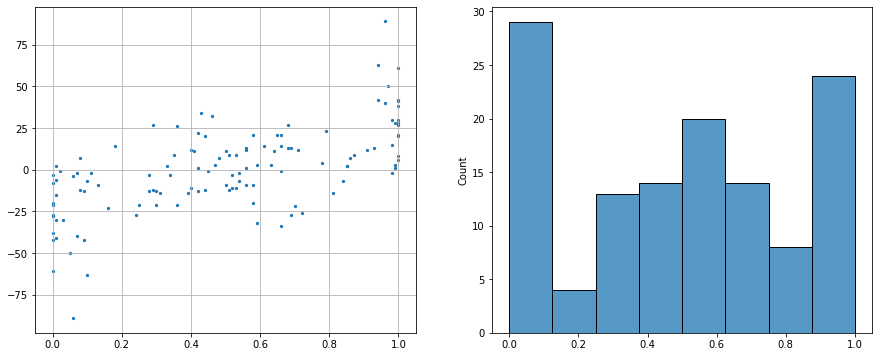


Validating on season 2018


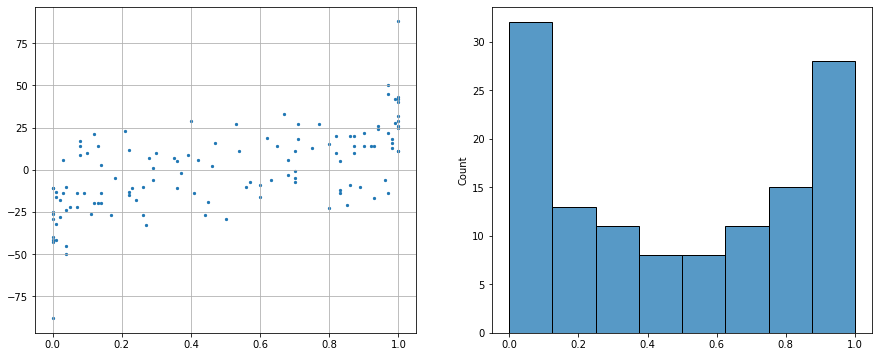


Validating on season 2019


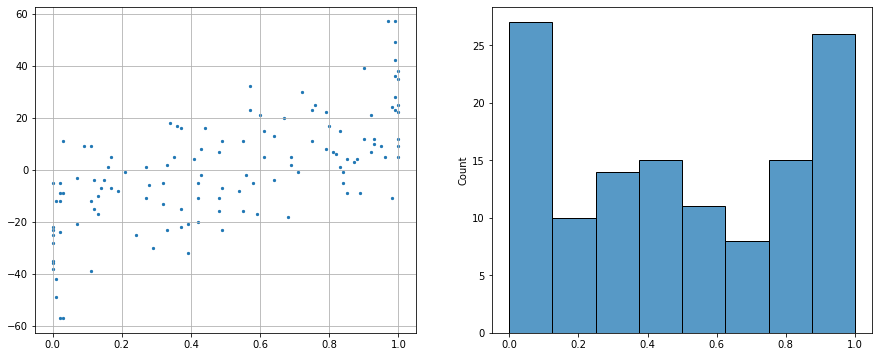


Validating on season 2021


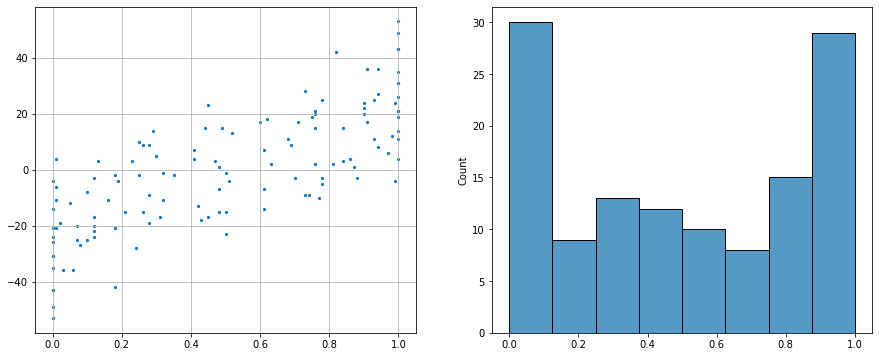

In [307]:
pred_tests = kfold(df, df_test, plot=True, verbose=1, mode="cls")

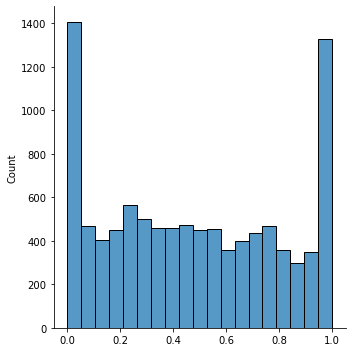

In [308]:
pred_test = np.mean(pred_tests, 0)

_ = sns.displot(pred_test)

# Submission

In [309]:
sub = df_test[['ID', 'Pred', 'TeamIdA', 'TeamIdB', 'SeedA', 'SeedB']].copy()
sub['Pred'] = pred_test

In [ ]:
final_sub = sub[['ID', 'Pred']].copy()
final_sub.to_csv('submission_rfxDetail.csv', index=False)